In [1]:
# Ensure you have the necessary libraries
!pip install numpy pot matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.5 MB/s eta 0:00:00


# 1. Imports and Setup

In [3]:
import numpy as np
import ot # Python Optimal Transport
import json
import os
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Notebook specific display options
%matplotlib inline
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:.3f}'.format

# --- Configuration (Can be loaded from external files in a real scenario) ---
STATE_FILE = "optimizer_state_notebook.json"

# 2. Define Intents, Flows, True Effectiveness, and Costs

In [4]:
INTENTS_CONFIG = {
    "CHECK_BALANCE": {
        "flows": ["DirectInquiry", "SecureVerifyThenInquiry", "FAQRedirectBalance"],
        "true_effectiveness": [0.85, 0.95, 0.30], # Hidden ground truth for simulation
        "user_utterances": ["What's my balance?", "Check my account balance"]
    },
    "TRANSFER_FUNDS": {
        "flows": ["QuickTransfer", "GuidedTransferWithConfirm", "ShowTransferLimitsInfo"],
        "true_effectiveness": [0.70, 0.90, 0.45],
        "user_utterances": ["Transfer money", "Send $50 to John"]
    },
    "RESET_PASSWORD": {
        "flows": ["SMS_OTP_Reset", "SecurityQuestionReset", "EmailLinkReset"],
        "true_effectiveness": [0.80, 0.65, 0.88],
        "user_utterances": ["I forgot my password", "Reset my login"]
    }
}

FLOW_COSTS_CONFIG = {}
for intent_name, intent_data in INTENTS_CONFIG.items():
    FLOW_COSTS_CONFIG[intent_name] = {}
    print(f"Intent: {intent_name}")
    for i, flow_name in enumerate(intent_data["flows"]):
        # Example cost: somewhat inversely related to true_effectiveness + base + small noise
        cost = (1.0 - intent_data["true_effectiveness"][i]) + 0.10 + (random.random() * 0.1 - 0.05)
        FLOW_COSTS_CONFIG[intent_name][flow_name] = max(0.01, round(cost, 2))
        print(f"  Flow: {flow_name:<25} | True Effect.: {intent_data['true_effectiveness'][i]:.2f} | Cost: {FLOW_COSTS_CONFIG[intent_name][flow_name]:.2f}")
    print("-" * 20)

Intent: CHECK_BALANCE
  Flow: DirectInquiry             | True Effect.: 0.85 | Cost: 0.23
  Flow: SecureVerifyThenInquiry   | True Effect.: 0.95 | Cost: 0.15
  Flow: FAQRedirectBalance        | True Effect.: 0.30 | Cost: 0.76
--------------------
Intent: TRANSFER_FUNDS
  Flow: QuickTransfer             | True Effect.: 0.70 | Cost: 0.37
  Flow: GuidedTransferWithConfirm | True Effect.: 0.90 | Cost: 0.24
  Flow: ShowTransferLimitsInfo    | True Effect.: 0.45 | Cost: 0.62
--------------------
Intent: RESET_PASSWORD
  Flow: SMS_OTP_Reset             | True Effect.: 0.80 | Cost: 0.26
  Flow: SecurityQuestionReset     | True Effect.: 0.65 | Cost: 0.48
  Flow: EmailLinkReset            | True Effect.: 0.88 | Cost: 0.23
--------------------


# 3. The AdaptiveConversationOptimizer Class

In [5]:
class AdaptiveConversationOptimizer:
    def __init__(self, intents_config, flow_costs_config, learning_rate=0.1, regularization_strength=0.05):
        self.intents_config = intents_config
        self.flow_costs_config = flow_costs_config
        self.learning_rate = learning_rate
        self.regularization_strength = regularization_strength

        self.flow_preference_scores = {}
        self.flow_observed_success_counts = {}
        self.flow_observed_total_counts = {}
        self._initialize_structures()

    def _initialize_structures(self):
        for intent_name, data in self.intents_config.items():
            num_flows = len(data["flows"])
            initial_scores = np.array([-self.flow_costs_config[intent_name][flow_name] for flow_name in data["flows"]])
            initial_scores = (initial_scores - np.mean(initial_scores)) * 0.05 # Small initial bias by cost

            self.flow_preference_scores[intent_name] = initial_scores if len(initial_scores) > 0 else np.zeros(num_flows)
            self.flow_observed_success_counts[intent_name] = np.zeros(num_flows)
            self.flow_observed_total_counts[intent_name] = np.zeros(num_flows)

    def _get_probabilities_from_scores(self, scores):
        if not isinstance(scores, np.ndarray) or scores.size == 0: return np.array([])
        if np.all(np.isclose(scores, scores[0])): # If all scores are same (e.g., all zeros)
            return np.ones_like(scores) / len(scores) if len(scores) > 0 else np.array([])

        stable_scores = np.nan_to_num(scores, nan=np.min(scores[~np.isnan(scores)]) if np.any(~np.isnan(scores)) else 0.0)
        exp_scores = np.exp(stable_scores - np.max(stable_scores)) # Softmax for stability
        sum_exp_scores = np.sum(exp_scores)
        if sum_exp_scores < 1e-9: # Avoid division by zero if all exp_scores are tiny
             return np.ones_like(scores) / len(scores) if len(scores) > 0 else np.array([])
        return exp_scores / sum_exp_scores

    def get_current_strategy(self, intent_name):
        scores = self.flow_preference_scores.get(intent_name)
        if scores is None: return np.array([])
        return self._get_probabilities_from_scores(scores)

    def choose_flow(self, intent_name):
        probabilities = self.get_current_strategy(intent_name)
        if len(probabilities) == 0:
            # Fallback for unconfigured intent or no flows
            if intent_name in self.intents_config and len(self.intents_config[intent_name]["flows"]) > 0:
                num_flows = len(self.intents_config[intent_name]["flows"])
                flow_index = np.random.choice(num_flows)
                return self.intents_config[intent_name]["flows"][flow_index], flow_index
            return None, -1

        flow_index = np.random.choice(len(probabilities), p=probabilities)
        chosen_flow_name = self.intents_config[intent_name]["flows"][flow_index]
        return chosen_flow_name, flow_index

    def simulate_interaction_and_get_feedback(self, intent_name, chosen_flow_index):
        true_effectiveness_list = self.intents_config[intent_name]["true_effectiveness"]
        success_prob = true_effectiveness_list[chosen_flow_index]
        return np.random.rand() < success_prob

    def record_and_process_feedback(self, intent_name, chosen_flow_index, was_successful):
        if chosen_flow_index < 0 or chosen_flow_index >= len(self.flow_observed_total_counts[intent_name]):
            # print(f"Error: chosen_flow_index {chosen_flow_index} out of bounds for {intent_name}.")
            return

        self.flow_observed_total_counts[intent_name][chosen_flow_index] += 1
        if was_successful:
            self.flow_observed_success_counts[intent_name][chosen_flow_index] += 1

        current_strategy_dist = self.get_current_strategy(intent_name)
        if len(current_strategy_dist) == 0: return

        success_rates = np.divide(
            self.flow_observed_success_counts[intent_name],
            self.flow_observed_total_counts[intent_name],
            out=np.zeros_like(self.flow_observed_success_counts[intent_name], dtype=float),
            where=self.flow_observed_total_counts[intent_name] != 0
        )

        # For target scores, use log of success rates; for unexplored flows, assign a neutral or slightly pessimistic score
        target_scores = np.log(success_rates + 1e-7) # Add epsilon for log(0) and stability
        unexplored_mask = (self.flow_observed_total_counts[intent_name] == 0)
        # Give unexplored flows a base score, e.g., equivalent to a 20% success rate if others are bad
        target_scores[unexplored_mask] = np.log(0.20 + 1e-7)

        if np.all(success_rates < 1e-5) and np.sum(self.flow_observed_total_counts[intent_name]) > 0: # All tried flows failed
             target_strategy_dist = np.ones_like(target_scores) / len(target_scores) if len(target_scores) > 0 else np.array([])
        elif np.sum(self.flow_observed_total_counts[intent_name]) == 0: # No data yet
            target_strategy_dist = current_strategy_dist
        else:
            target_strategy_dist = self._get_probabilities_from_scores(target_scores)

        if len(target_strategy_dist) == 0 : return

        num_flows = len(self.intents_config[intent_name]["flows"])
        cost_matrix = np.zeros((num_flows, num_flows))
        intent_flow_names = self.intents_config[intent_name]["flows"]
        for j in range(num_flows):
            flow_j_name = intent_flow_names[j]
            cost_matrix[:, j] = self.flow_costs_config[intent_name][flow_j_name]

        epsilon_dist = 1e-9
        current_strategy_dist_stable = np.maximum(current_strategy_dist, epsilon_dist)
        current_strategy_dist_stable /= np.sum(current_strategy_dist_stable)
        target_strategy_dist_stable = np.maximum(target_strategy_dist, epsilon_dist)
        target_strategy_dist_stable /= np.sum(target_strategy_dist_stable)

        try:
            # Regularized Optimal Transport (Sinkhorn)
            G = ot.sinkhorn(current_strategy_dist_stable, target_strategy_dist_stable,
                            cost_matrix, self.regularization_strength, verbose=False, numItermax=100)
        except Exception as e:
            # Fallback if Sinkhorn fails (e.g., due to all-zero rows/cols in cost or distributions)
            # print(f"Sinkhorn failed for {intent_name}: {e}. Using simpler update.")
            # A very simple fallback: just move towards the target distribution directly
            G_fallback_col_sum = target_strategy_dist_stable
            # To form a G matrix for consistent update logic:
            G = np.outer(current_strategy_dist_stable, G_fallback_col_sum) * num_flows

        new_flow_probabilities = G.sum(axis=0)
        if not np.allclose(np.sum(new_flow_probabilities), 1.0) and np.sum(new_flow_probabilities) > 1e-6 :
            new_flow_probabilities /= np.sum(new_flow_probabilities)
        elif np.sum(new_flow_probabilities) <= 1e-6 :
             new_flow_probabilities = np.ones_like(new_flow_probabilities) / len(new_flow_probabilities) if len(new_flow_probabilities) > 0 else np.array([])

        if len(new_flow_probabilities) == 0: return

        target_preference_scores_update = np.log(new_flow_probabilities + 1e-9)

        current_scores = self.flow_preference_scores[intent_name]
        # Ensure current_scores and target_preference_scores_update have the same shape
        if current_scores.shape != target_preference_scores_update.shape:
            # print(f"Shape mismatch for {intent_name}. Current: {current_scores.shape}, Target: {target_preference_scores_update.shape}. Skipping update.")
            return

        updated_scores = current_scores + self.learning_rate * (target_preference_scores_update - current_scores)
        self.flow_preference_scores[intent_name] = updated_scores

    def save_state(self, filepath=STATE_FILE):
        state = {
            "flow_preference_scores": {k: v.tolist() for k, v in self.flow_preference_scores.items()},
            "flow_observed_success_counts": {k: v.tolist() for k, v in self.flow_observed_success_counts.items()},
            "flow_observed_total_counts": {k: v.tolist() for k, v in self.flow_observed_total_counts.items()},
        }
        with open(filepath, 'w') as f:
            json.dump(state, f, indent=2)

    def load_state(self, filepath=STATE_FILE):
        if os.path.exists(filepath):
            try:
                with open(filepath, 'r') as f:
                    state = json.load(f)
                self._initialize_structures() # Reset first, then overlay
                for intent_name in self.intents_config:
                    if intent_name in state["flow_preference_scores"] and \
                       len(state["flow_preference_scores"][intent_name]) == len(self.flow_preference_scores[intent_name]):
                        self.flow_preference_scores[intent_name] = np.array(state["flow_preference_scores"][intent_name])
                    if intent_name in state["flow_observed_success_counts"] and \
                       len(state["flow_observed_success_counts"][intent_name]) == len(self.flow_observed_success_counts[intent_name]):
                        self.flow_observed_success_counts[intent_name] = np.array(state["flow_observed_success_counts"][intent_name])
                    if intent_name in state["flow_observed_total_counts"] and \
                       len(state["flow_observed_total_counts"][intent_name]) == len(self.flow_observed_total_counts[intent_name]):
                        self.flow_observed_total_counts[intent_name] = np.array(state["flow_observed_total_counts"][intent_name])
            except Exception as e:
                print(f"Error loading state: {e}. Starting fresh.")
                self._initialize_structures()
        else:
            self._initialize_structures() # Initialize if no file

# 4. Helper Function for Visualization

In [9]:
def plot_strategy_evolution(history_df, intent_name_to_plot):
    # Filter for the specific intent
    intent_history = history_df[history_df['Intent'] == intent_name_to_plot].copy() # Use .copy() to avoid SettingWithCopyWarning
    if intent_history.empty:
        print(f"No history found for intent: {intent_name_to_plot}")
        return

    plt.figure(figsize=(14, 7))

    # Get the flow names *specifically for this intent*
    flow_names_for_this_intent = INTENTS_CONFIG[intent_name_to_plot]["flows"]

    for i, flow_name in enumerate(flow_names_for_this_intent):
        # The column name for probability is simply 'Prob' in our refined history_df
        # We will filter the DataFrame further for each flow
        flow_specific_history = intent_history[intent_history['Flow'] == flow_name]

        if not flow_specific_history.empty:
            true_eff = INTENTS_CONFIG[intent_name_to_plot]["true_effectiveness"][i]
            cost = FLOW_COSTS_CONFIG[intent_name_to_plot][flow_name]
            label = f"{flow_name} (TrueEff: {true_eff:.2f}, Cost: {cost:.2f})"

            # 'Prob' column already exists from get_status_df
            sns.lineplot(data=flow_specific_history, x='Interaction', y='Prob', label=label, lw=2)
        else:
            print(f"No history data for flow '{flow_name}' in intent '{intent_name_to_plot}'. Skipping its line.")


    plt.title(f'Evolution of Flow Probabilities for Intent: {intent_name_to_plot}')
    plt.xlabel('Interaction Number')
    plt.ylabel('Probability of Choosing Flow')
    plt.legend(title='Flows', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1.05) # Ensure y-axis is between 0 and 1 for probabilities
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()

def get_status_df(optimizer, interaction_num):
    rows = []
    for intent_name, data in optimizer.intents_config.items():
        current_probs = optimizer.get_current_strategy(intent_name)
        for i, flow_name in enumerate(data["flows"]):
            prob = current_probs[i] if i < len(current_probs) else 0.0 # Probability for this specific flow
            obs_succ = optimizer.flow_observed_success_counts[intent_name][i]
            obs_tot = optimizer.flow_observed_total_counts[intent_name][i]
            obs_rate = obs_succ / obs_tot if obs_tot > 0 else 0.0
            true_eff = data["true_effectiveness"][i]
            cost = optimizer.flow_costs_config[intent_name][flow_name]

            row_data = {
                'Interaction': interaction_num,
                'Intent': intent_name,
                'Flow': flow_name, # Store the actual flow name
                'Prob': prob,     # This is the probability of *this specific flow* being chosen for this intent
                'Observed_Successes': int(obs_succ),
                'Observed_Trials': int(obs_tot),
                'Observed_Rate': obs_rate,
                'True_Effectiveness': true_eff,
                'Cost': cost
            }
            rows.append(row_data)

    raw_df = pd.DataFrame(rows)

    # Create a summary for printing (this is what you were seeing in the output)
    summary_rows_for_print = []
    for intent_name in optimizer.intents_config.keys():
        current_probs_for_intent = optimizer.get_current_strategy(intent_name)
        flows_for_intent = optimizer.intents_config[intent_name]["flows"]
        obs_success_for_intent = optimizer.flow_observed_success_counts[intent_name]
        obs_totals_for_intent = optimizer.flow_observed_total_counts[intent_name]

        for i, flow_name in enumerate(flows_for_intent):
            prob_val = current_probs_for_intent[i] if i < len(current_probs_for_intent) else 0.0
            obs_total_val = obs_totals_for_intent[i]
            obs_rate_val = (obs_success_for_intent[i] / obs_total_val) if obs_total_val > 0 else 0.0

            summary_rows_for_print.append({
                 "Intent": intent_name,
                 "Flow": flow_name,
                 "Prob": prob_val,
                 "Obs Rate": obs_rate_val,
                 "Trials": int(obs_total_val)
             })
    summary_df_for_print = pd.DataFrame(summary_rows_for_print).set_index(['Intent', 'Flow'])

    return summary_df_for_print, raw_df # Return summary for printing and raw_df for history

# 5. Simulation Run Configuration

In [13]:
# Delete previous state to start fresh for the demo run (optional)
if os.path.exists(STATE_FILE):
    os.remove(STATE_FILE)
    print(f"Deleted previous state file: {STATE_FILE} for a fresh demo run.")

optimizer = AdaptiveConversationOptimizer(
    INTENTS_CONFIG,
    FLOW_COSTS_CONFIG,
    learning_rate=0.20,         # How quickly the agent adapts (0.1-0.3 is often a good start)
    regularization_strength=0.01 # Lower reg = closer to pure OT; Higher reg = more entropic/smoother transport plan
)
optimizer.load_state() # Will start fresh if file was deleted or doesn't exist

NUM_INTERACTIONS = 2000        # Total interactions to simulate
REPORT_EVERY_N_INTERACTIONS = 200 # How often to print status and plot

# For storing history for plotting
print("--- Initial Optimizer Status ---")
initial_status_df_print, initial_status_df_raw = get_status_df(optimizer, 0) # Get both summary and raw
print(initial_status_df_print)
history_records = [initial_status_df_raw] # Initialize history_records as a list with the first raw_df

Deleted previous state file: optimizer_state_notebook.json for a fresh demo run.
--- Initial Optimizer Status ---
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.336     0.000       0
               SecureVerifyThenInquiry   0.337     0.000       0
               FAQRedirectBalance        0.327     0.000       0
TRANSFER_FUNDS QuickTransfer             0.334     0.000       0
               GuidedTransferWithConfirm 0.336     0.000       0
               ShowTransferLimitsInfo    0.330     0.000       0
RESET_PASSWORD SMS_OTP_Reset             0.334     0.000       0
               SecurityQuestionReset     0.331     0.000       0
               EmailLinkReset            0.335     0.000       0


# 6. Main Simulation Loop


--- Status after 200 interactions ---
Overall success rate so far: 81.50%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.449     0.821      28
               SecureVerifyThenInquiry   0.551     1.000      38
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.420     0.690      29
               GuidedTransferWithConfirm 0.580     0.944      36
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.424     0.867      30
               SecurityQuestionReset     0.208     0.476      21
               EmailLinkReset            0.369     0.750      16


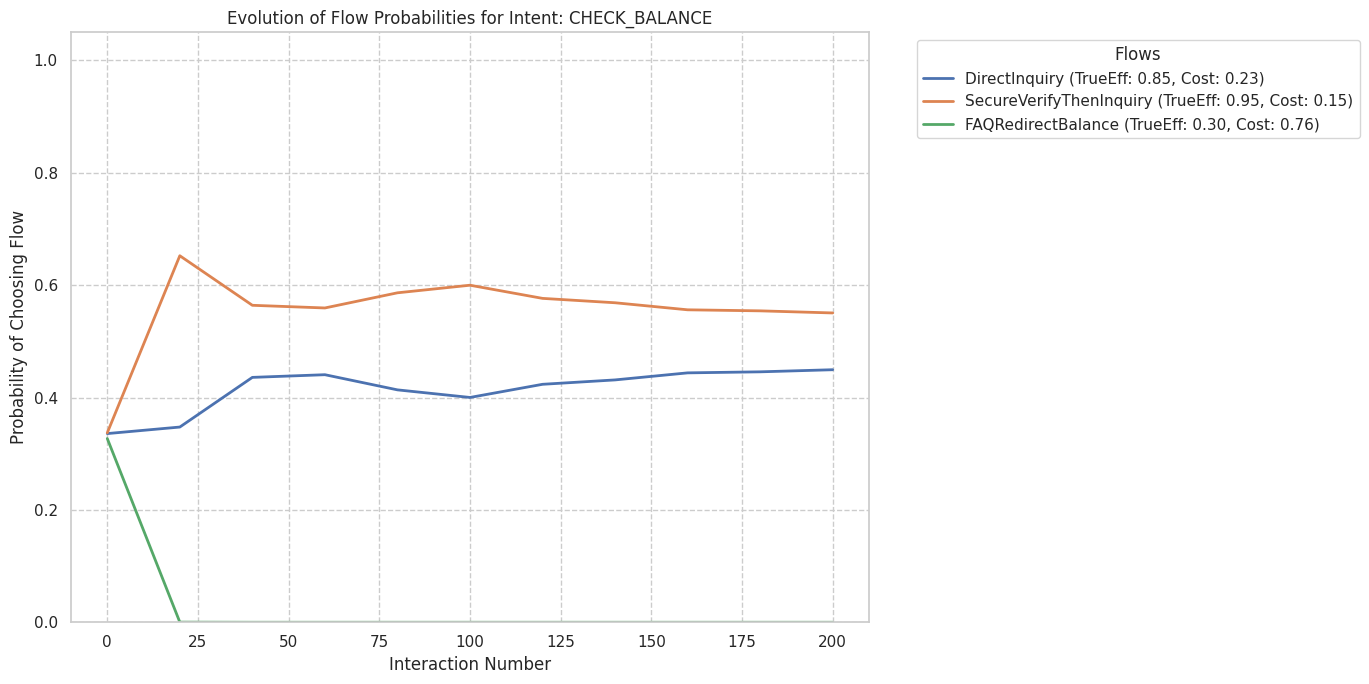

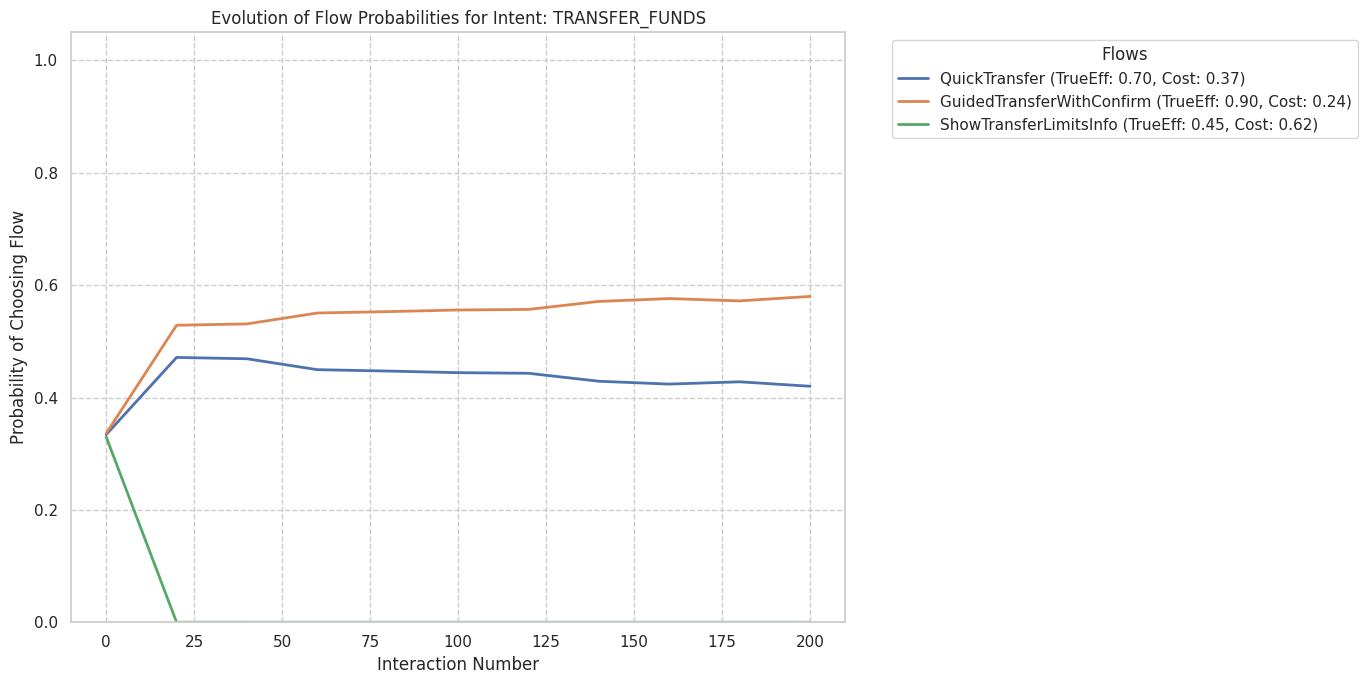


--- Status after 400 interactions ---
Overall success rate so far: 84.00%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.465     0.845      58
               SecureVerifyThenInquiry   0.535     0.974      77
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.456     0.750      60
               GuidedTransferWithConfirm 0.544     0.913      69
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.392     0.883      60
               SecurityQuestionReset     0.223     0.500      34
               EmailLinkReset            0.385     0.850      40


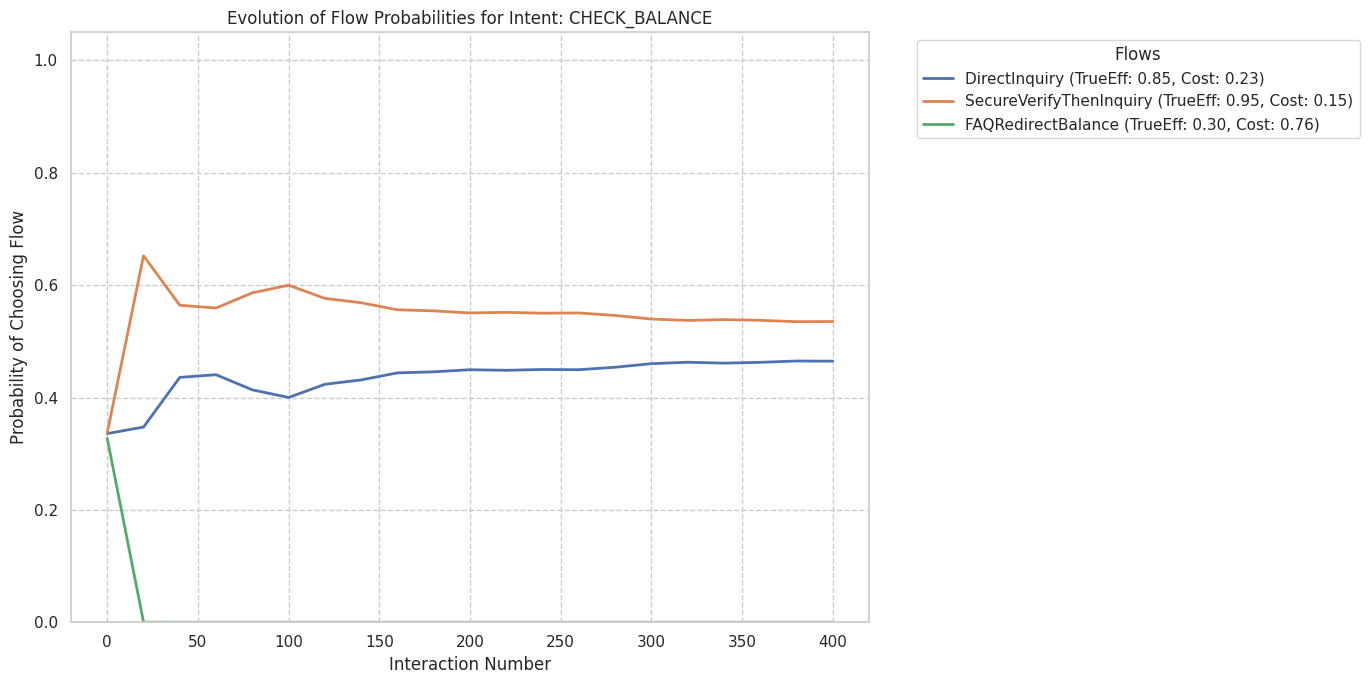

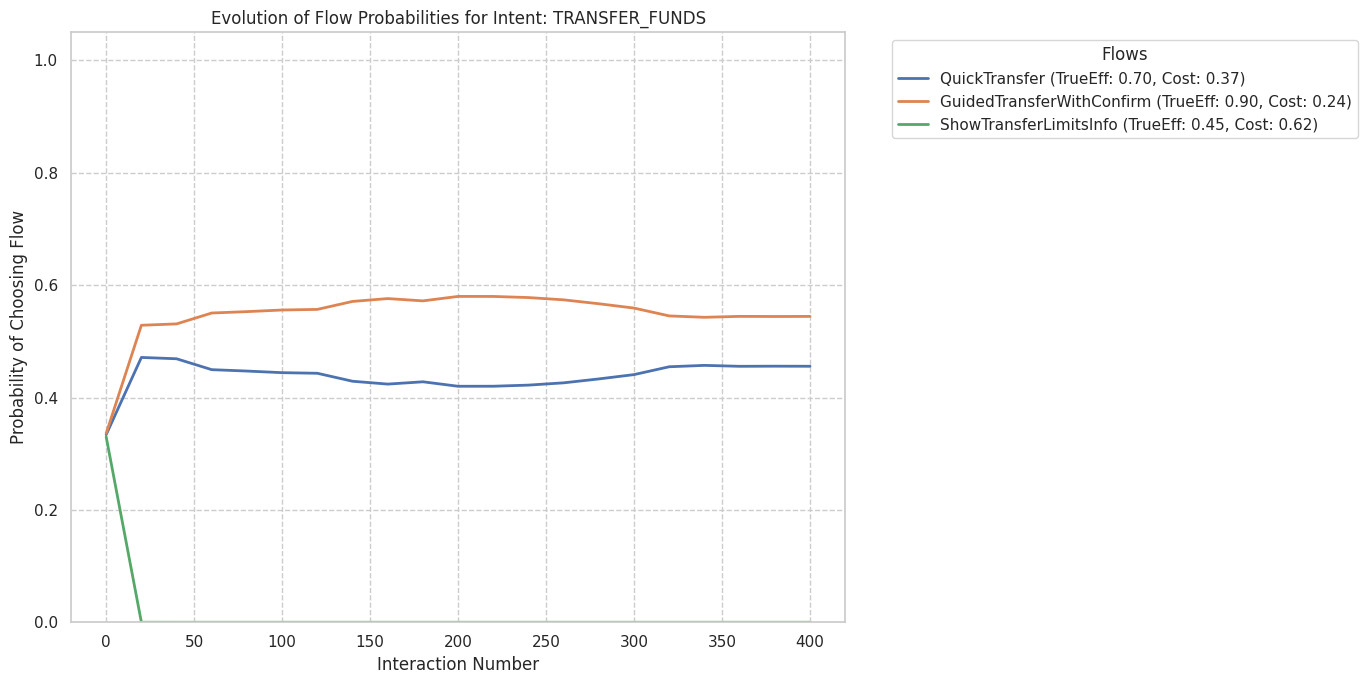


--- Status after 600 interactions ---
Overall success rate so far: 85.00%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.472     0.862      94
               SecureVerifyThenInquiry   0.528     0.965     113
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.457     0.744      86
               GuidedTransferWithConfirm 0.543     0.897     107
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.377     0.864      88
               SecurityQuestionReset     0.233     0.537      41
               EmailLinkReset            0.389     0.899      69


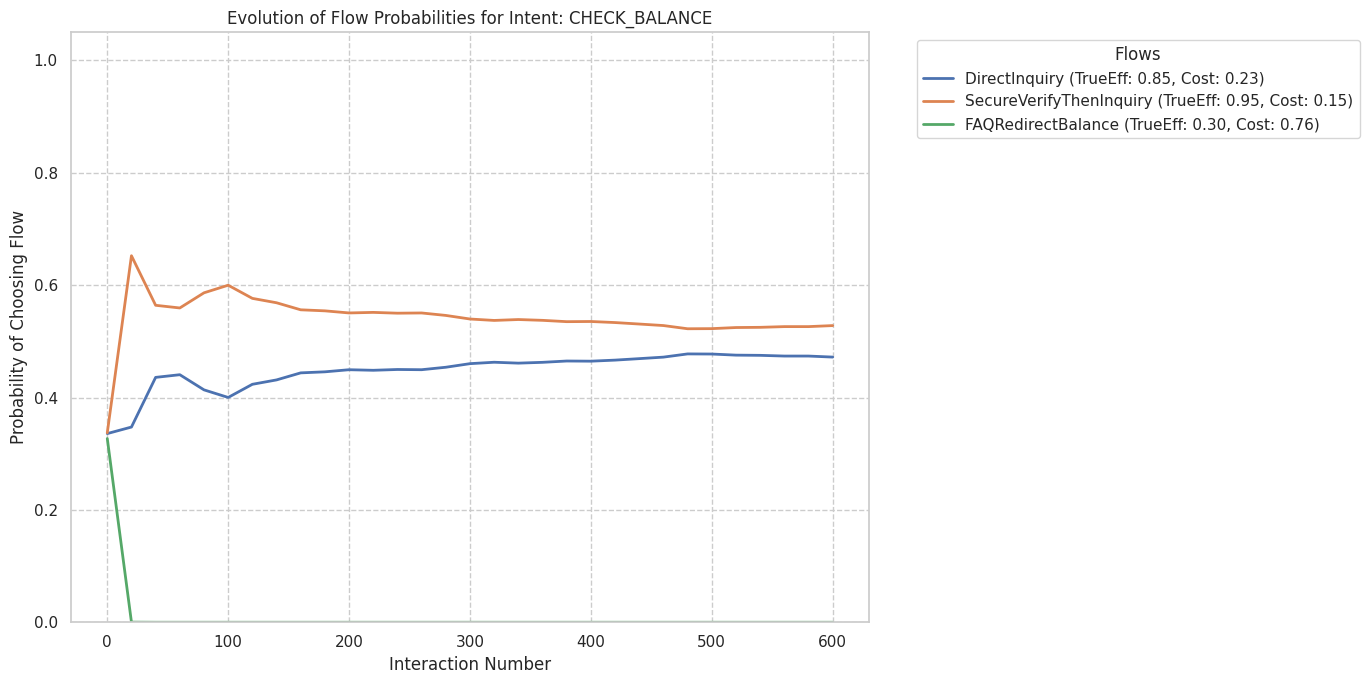

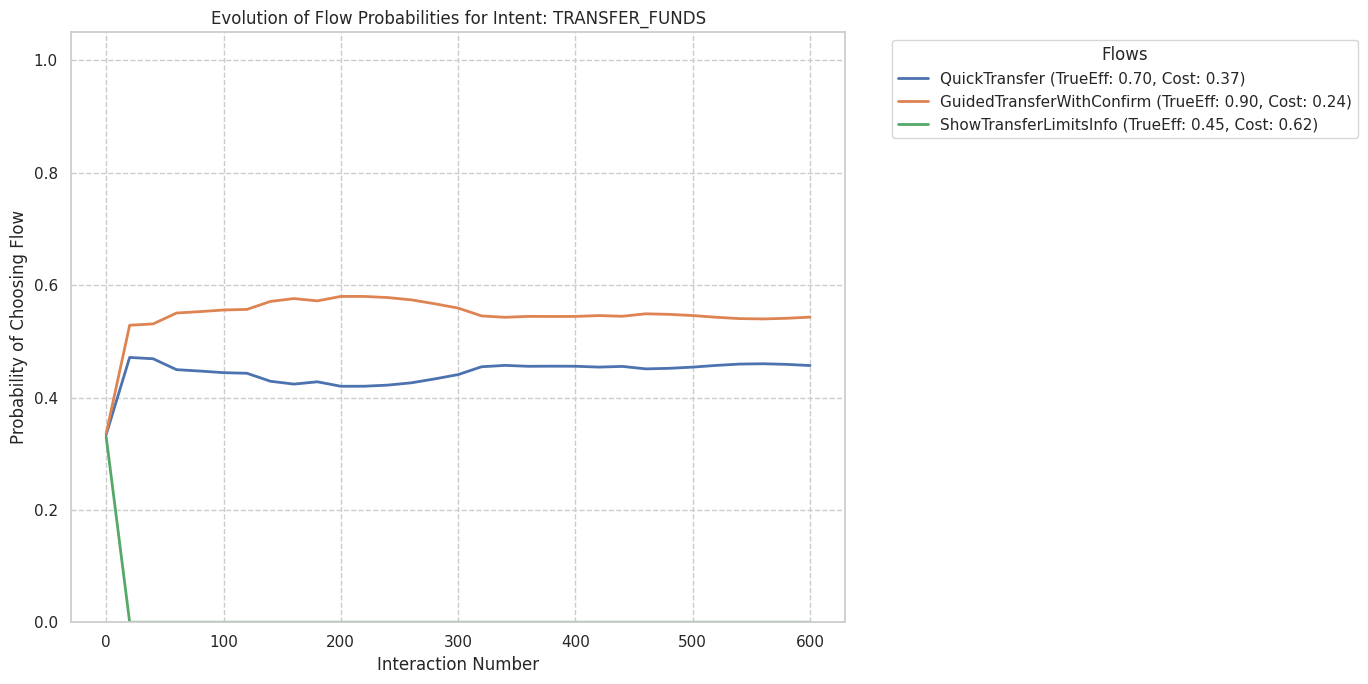


--- Status after 800 interactions ---
Overall success rate so far: 85.12%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.476     0.875     128
               SecureVerifyThenInquiry   0.524     0.964     139
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.456     0.754     118
               GuidedTransferWithConfirm 0.544     0.899     129
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.370     0.851     121
               SecurityQuestionReset     0.235     0.536      56
               EmailLinkReset            0.394     0.907     107


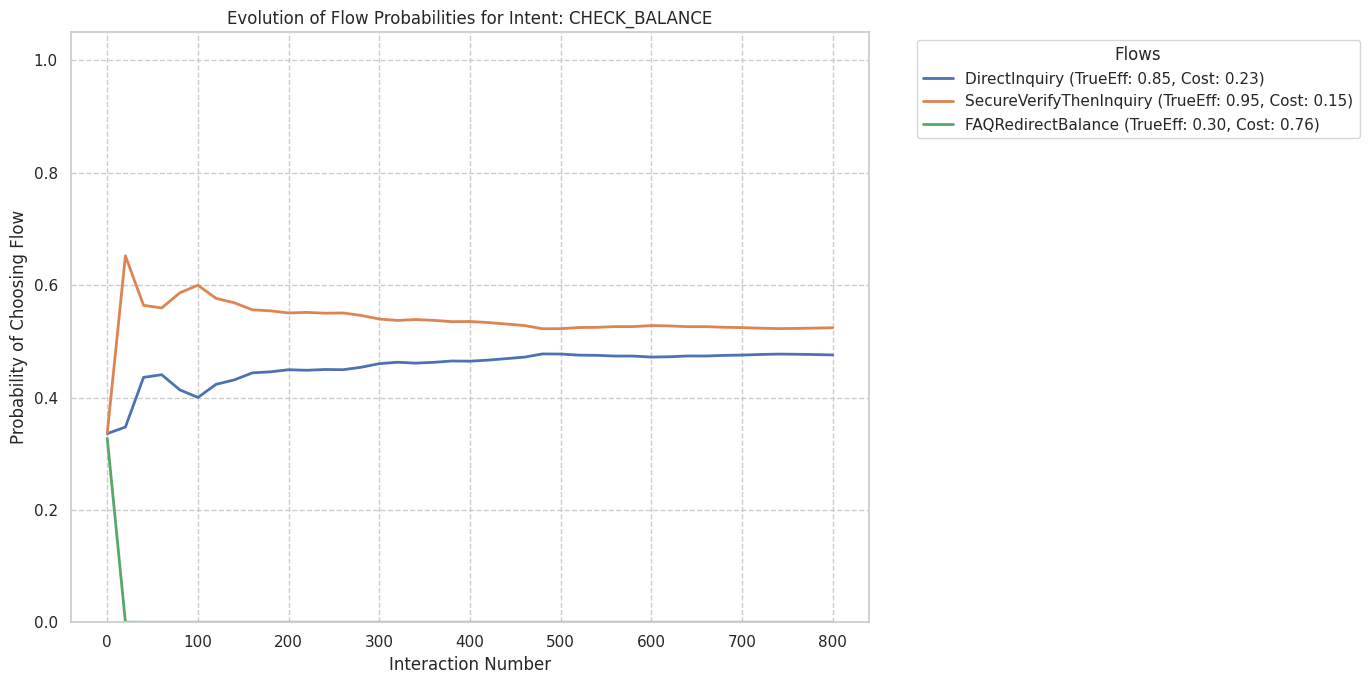

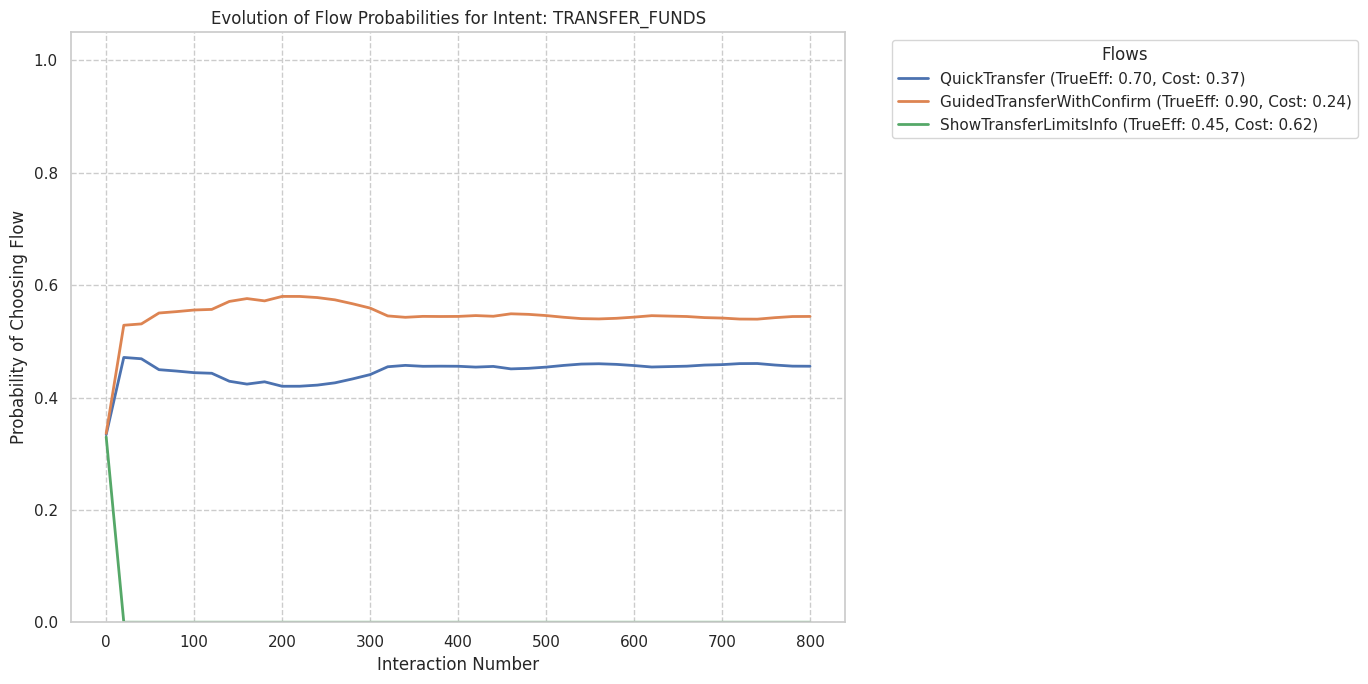


--- Status after 1000 interactions ---
Overall success rate so far: 85.30%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.472     0.856     167
               SecureVerifyThenInquiry   0.528     0.955     178
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.458     0.769     147
               GuidedTransferWithConfirm 0.542     0.909     165
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.367     0.852     135
               SecurityQuestionReset     0.244     0.563      71
               EmailLinkReset            0.389     0.904     135


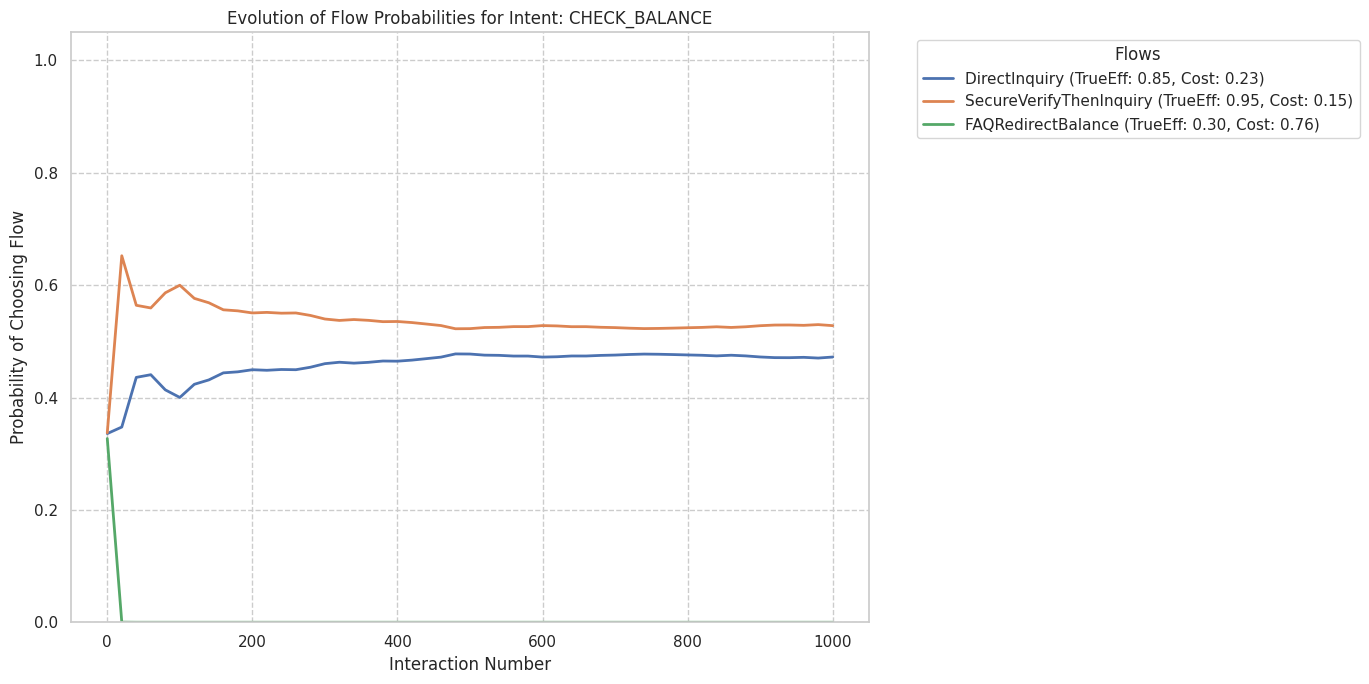

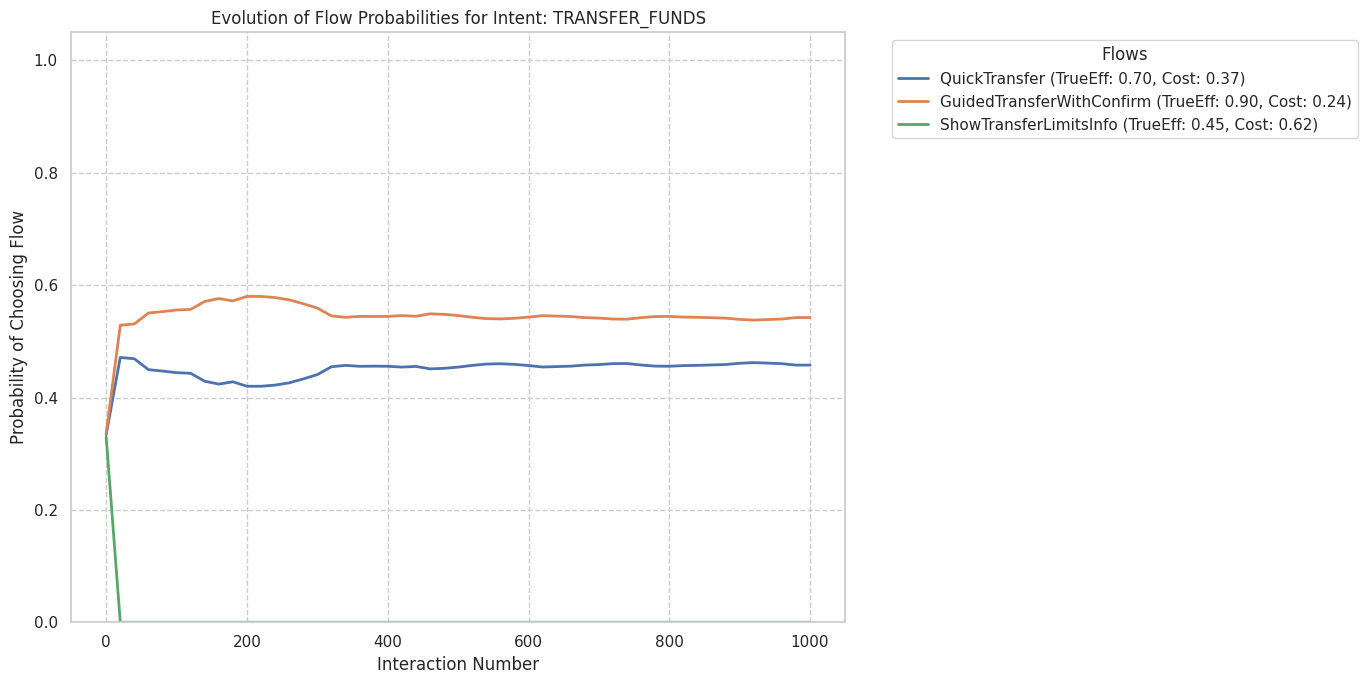


--- Status after 1200 interactions ---
Overall success rate so far: 85.00%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.468     0.846     195
               SecureVerifyThenInquiry   0.532     0.963     215
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.452     0.756     176
               GuidedTransferWithConfirm 0.548     0.919     197
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.361     0.830     165
               SecurityQuestionReset     0.250     0.576      85
               EmailLinkReset            0.389     0.897     165


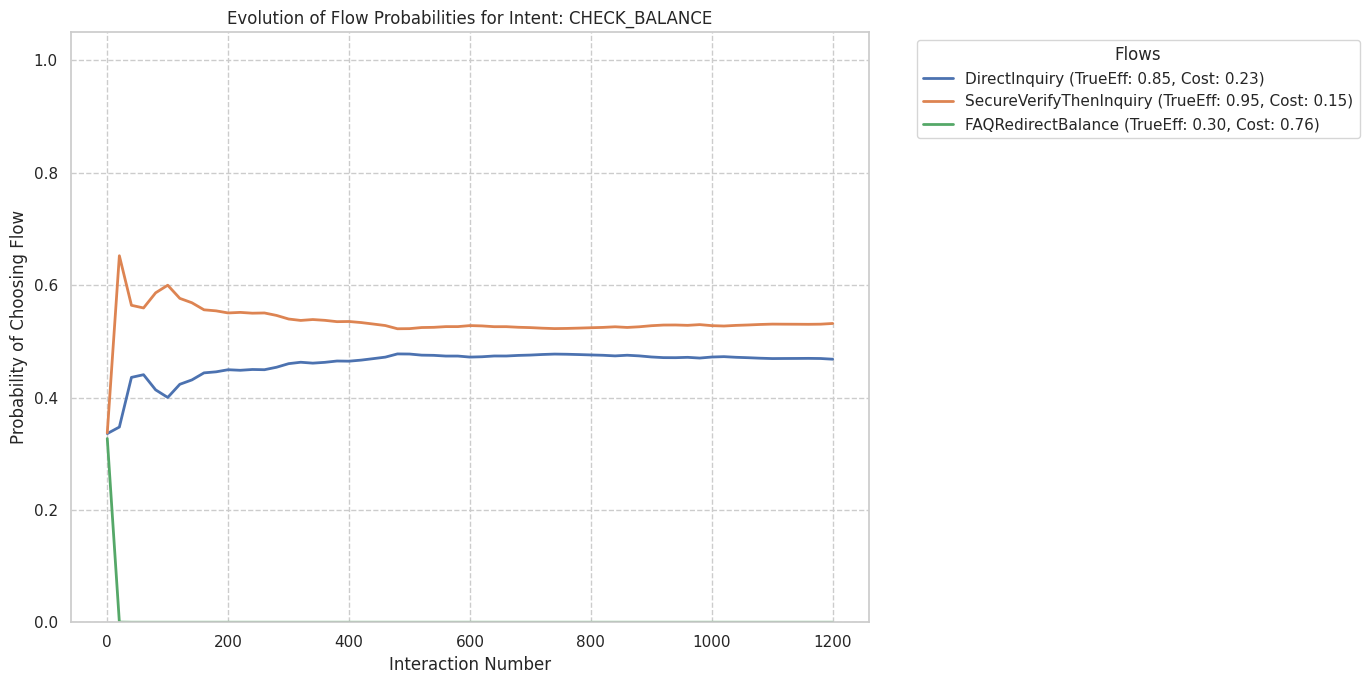

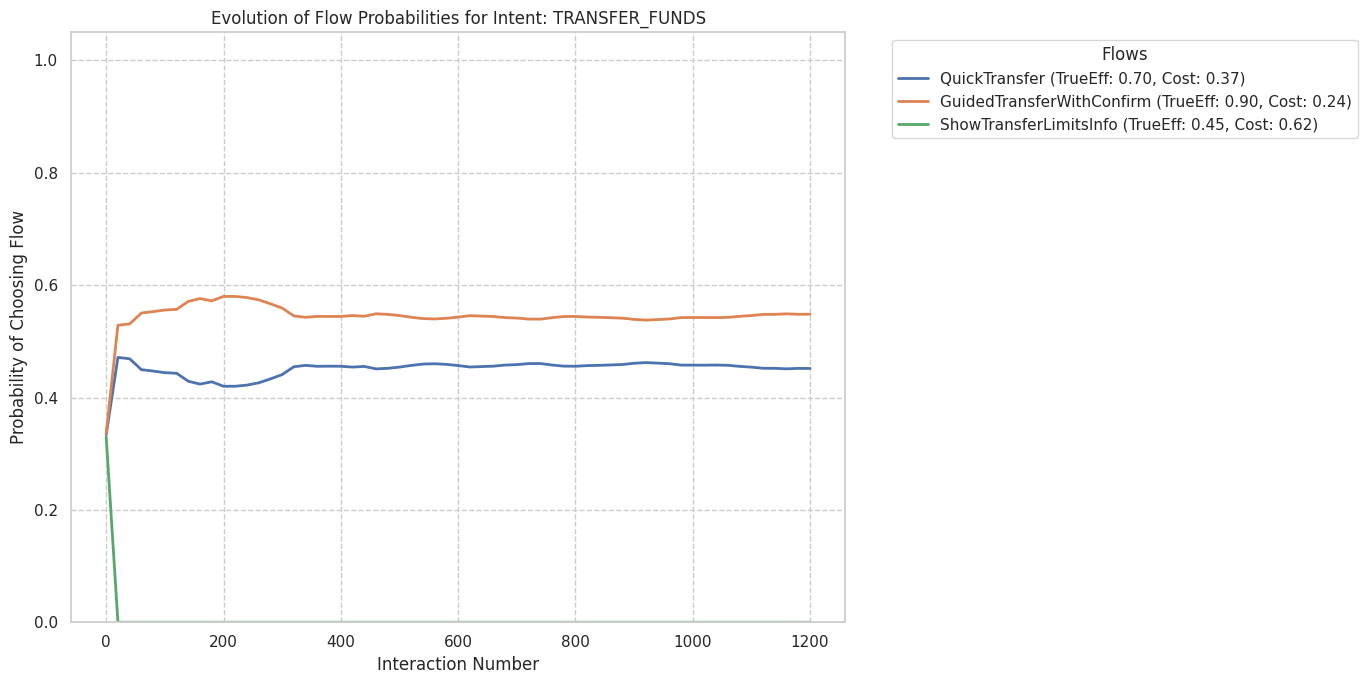


--- Status after 1400 interactions ---
Overall success rate so far: 85.14%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.469     0.851     215
               SecureVerifyThenInquiry   0.531     0.964     253
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.447     0.745     208
               GuidedTransferWithConfirm 0.553     0.924     237
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.353     0.816     185
               SecurityQuestionReset     0.257     0.598     102
               EmailLinkReset            0.390     0.904     198


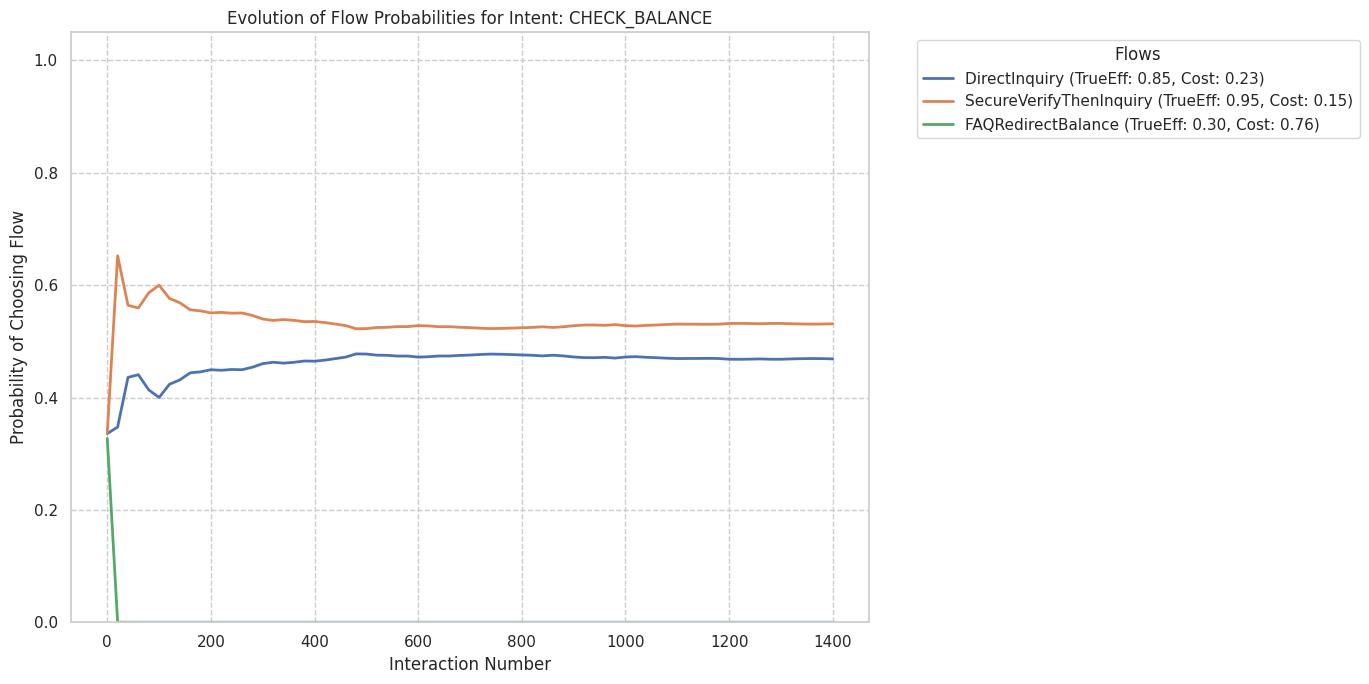

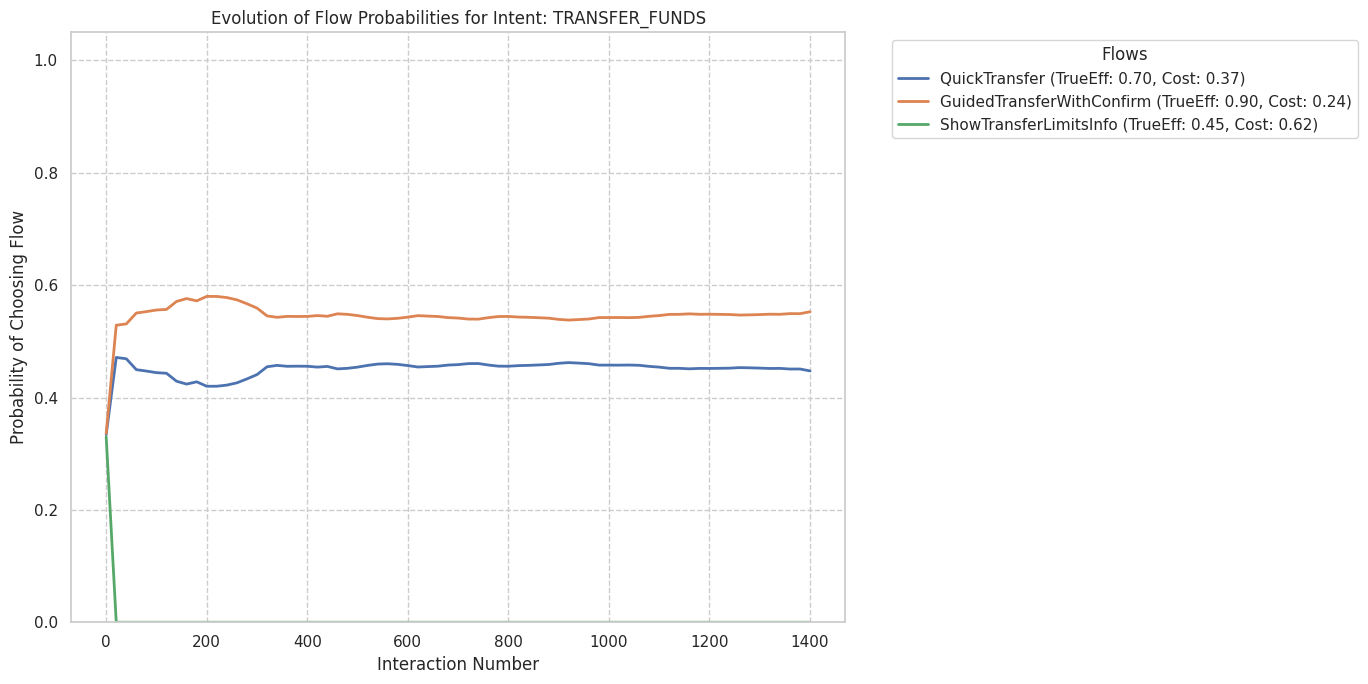


--- Status after 1600 interactions ---
Overall success rate so far: 85.25%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.471     0.858     254
               SecureVerifyThenInquiry   0.529     0.962     291
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.444     0.734     229
               GuidedTransferWithConfirm 0.556     0.919     273
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.351     0.822     213
               SecurityQuestionReset     0.263     0.619     118
               EmailLinkReset            0.387     0.905     220


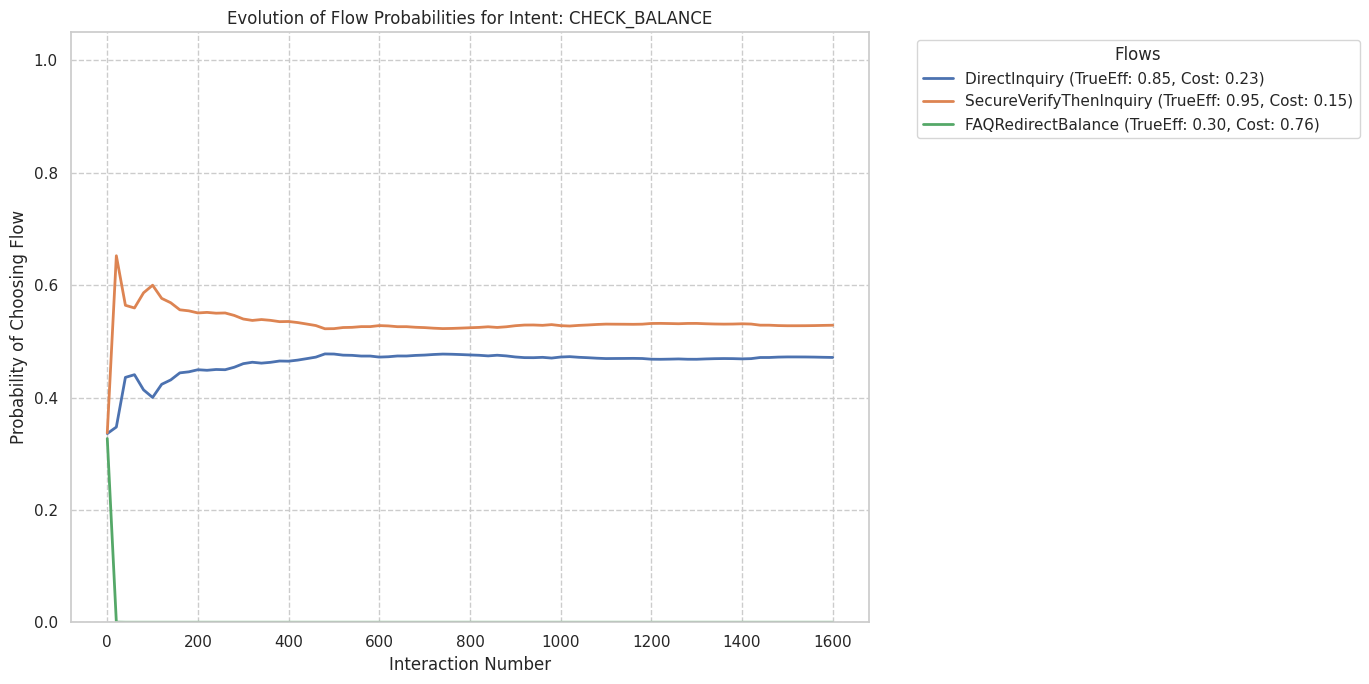

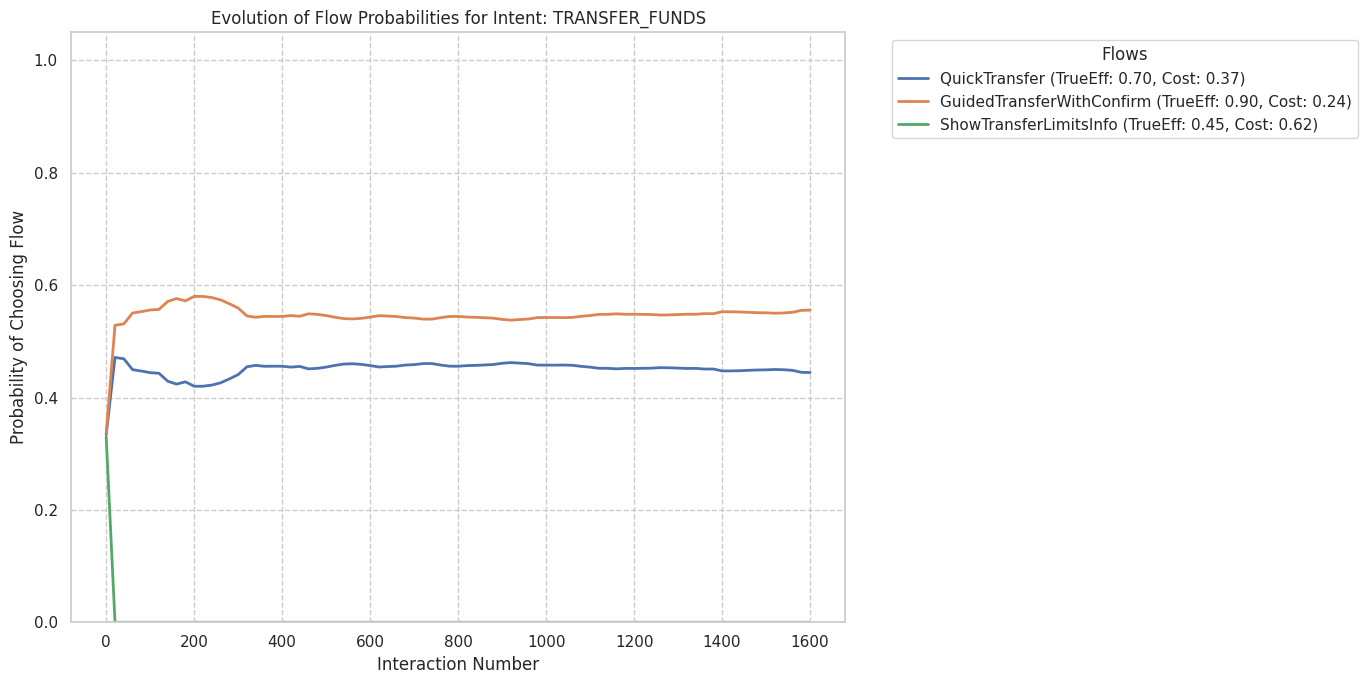


--- Status after 1800 interactions ---
Overall success rate so far: 84.83%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.469     0.851     275
               SecureVerifyThenInquiry   0.531     0.963     326
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.441     0.725     258
               GuidedTransferWithConfirm 0.559     0.917     313
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.352     0.818     242
               SecurityQuestionReset     0.261     0.610     136
               EmailLinkReset            0.387     0.903     248


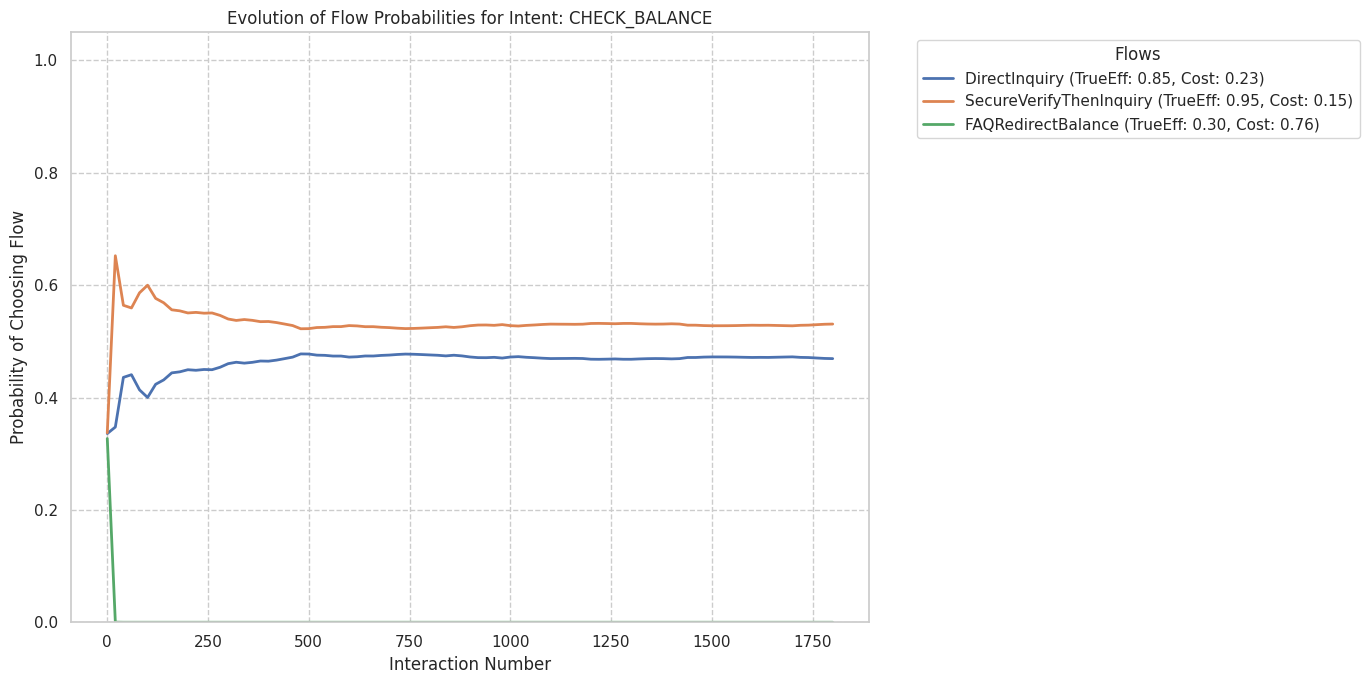

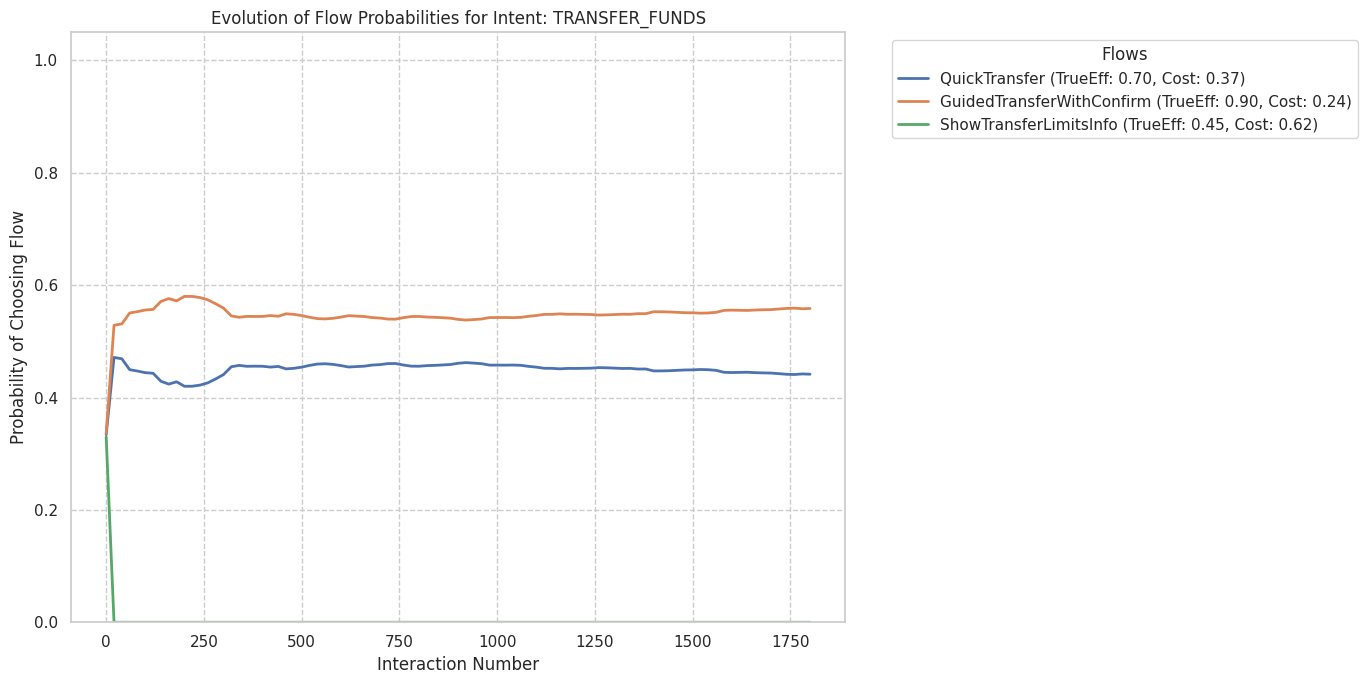


--- Status after 2000 interactions ---
Overall success rate so far: 84.85%
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.474     0.866     305
               SecureVerifyThenInquiry   0.526     0.961     362
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.442     0.727     282
               GuidedTransferWithConfirm 0.558     0.919     346
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.353     0.821     273
               SecurityQuestionReset     0.263     0.606     160
               EmailLinkReset            0.384     0.893     270


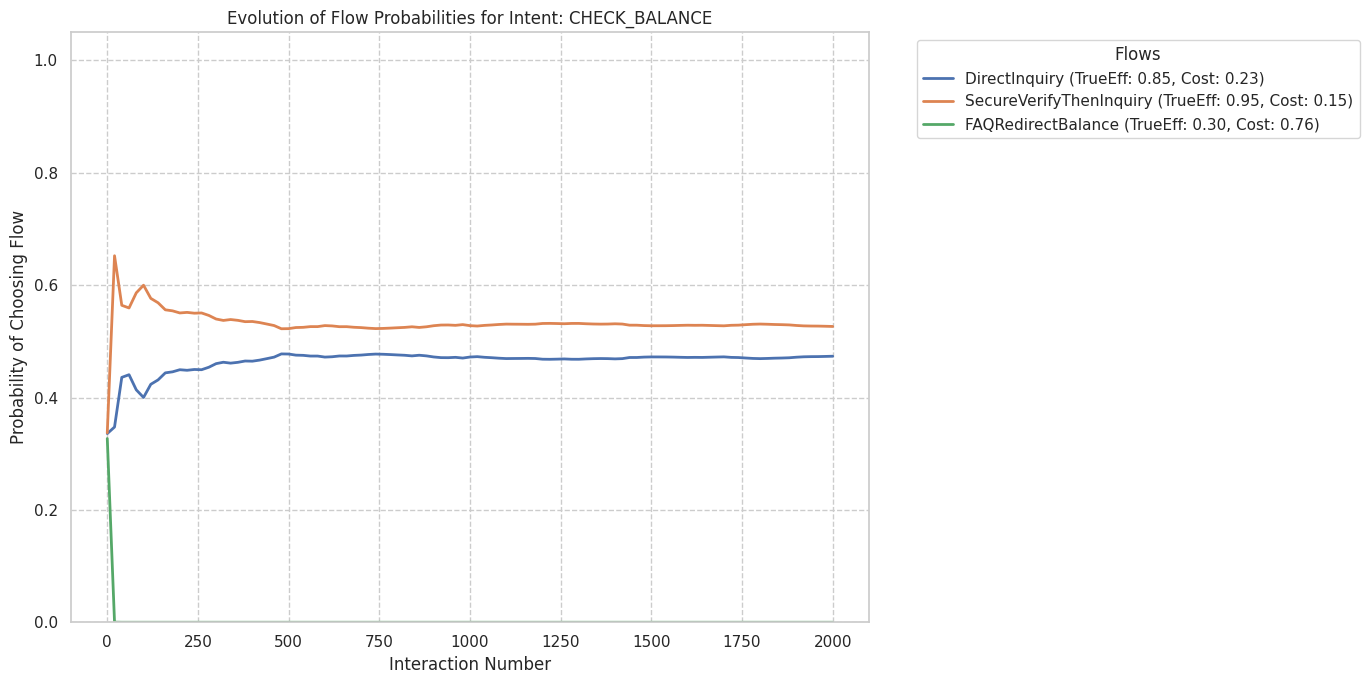

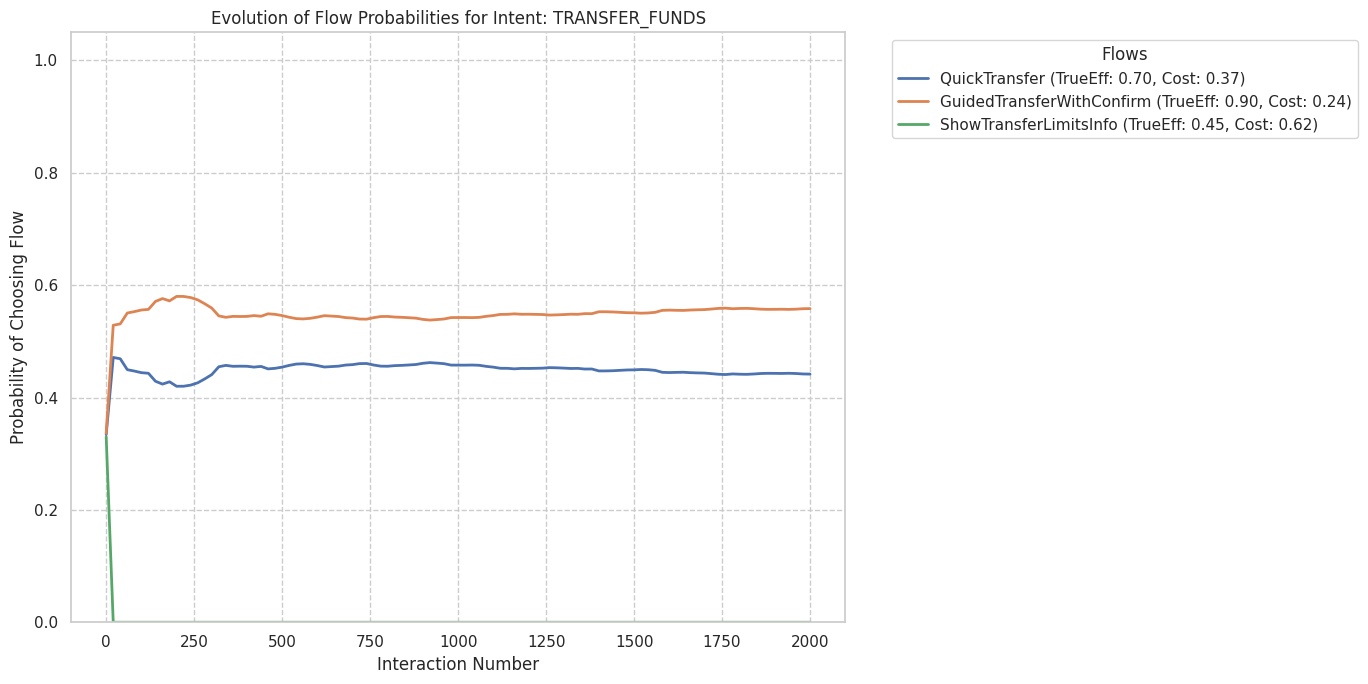


--- Simulation Complete ---
Total interactions: 2000
Overall final success rate: 84.85%
Simulation took: 8.38 seconds

Final Optimizer Status:
                                          Prob  Obs Rate  Trials
Intent         Flow                                             
CHECK_BALANCE  DirectInquiry             0.474     0.866     305
               SecureVerifyThenInquiry   0.526     0.961     362
               FAQRedirectBalance        0.000     0.000       1
TRANSFER_FUNDS QuickTransfer             0.442     0.727     282
               GuidedTransferWithConfirm 0.558     0.919     346
               ShowTransferLimitsInfo    0.000     0.000       1
RESET_PASSWORD SMS_OTP_Reset             0.353     0.821     273
               SecurityQuestionReset     0.263     0.606     160
               EmailLinkReset            0.384     0.893     270


In [14]:
total_successful_interactions = 0
start_time = time.time()

for i in range(1, NUM_INTERACTIONS + 1):
    # Simulate a user initiating a conversation by randomly picking an intent
    intent_name = random.choice(list(INTENTS_CONFIG.keys()))
    # simulated_utterance = random.choice(INTENTS_CONFIG[intent_name]["user_utterances"]) # Not used in logic, just for flavor

    chosen_flow_name, chosen_flow_index = optimizer.choose_flow(intent_name)

    if chosen_flow_name is None: # Should not happen with proper config
        continue

    was_successful = optimizer.simulate_interaction_and_get_feedback(intent_name, chosen_flow_index)
    if was_successful:
        total_successful_interactions += 1

    optimizer.record_and_process_feedback(intent_name, chosen_flow_index, was_successful)

    # Store data for plotting and reporting
    # Store more frequently for smoother plots, or at least at report intervals and the end
    if i % (REPORT_EVERY_N_INTERACTIONS // 10) == 0 or i == NUM_INTERACTIONS or i % REPORT_EVERY_N_INTERACTIONS == 0 :
        _, current_status_df_raw = get_status_df(optimizer, i) # Get the raw_df for history
        history_records.append(current_status_df_raw)


    if i % REPORT_EVERY_N_INTERACTIONS == 0 or i == NUM_INTERACTIONS:
        print(f"\n--- Status after {i} interactions ---")
        current_success_rate = (total_successful_interactions / i) * 100
        print(f"Overall success rate so far: {current_success_rate:.2f}%")

        status_df_print, _ = get_status_df(optimizer, i) # Get summary_df for printing
        print(status_df_print)

        optimizer.save_state() # Save progress

        # Combine history for plotting
        if history_records: # Make sure history_records is not empty
            combined_history_df = pd.concat(history_records)

            # Plot for example intents
            plot_strategy_evolution(combined_history_df, "CHECK_BALANCE")
            if "TRANSFER_FUNDS" in INTENTS_CONFIG:
                 plot_strategy_evolution(combined_history_df, "TRANSFER_FUNDS")
            # Can add more intents to plot here if desired
            # if "RESET_PASSWORD" in INTENTS_CONFIG:
            #      plot_strategy_evolution(combined_history_df, "RESET_PASSWORD")
        else:
            print("No history to plot yet.")


end_time = time.time()
print(f"\n--- Simulation Complete ---")
print(f"Total interactions: {NUM_INTERACTIONS}")
print(f"Overall final success rate: {(total_successful_interactions / NUM_INTERACTIONS) * 100:.2f}%")
print(f"Simulation took: {end_time - start_time:.2f} seconds")

final_status_df_print, _ = get_status_df(optimizer, NUM_INTERACTIONS) # Get summary_df for printing
print("\nFinal Optimizer Status:")
print(final_status_df_print)

# 7. Analyze Final State and Potential Insights


--- Detailed Final Analysis for Each Intent ---

Intent: CHECK_BALANCE
                      Flow  Final Probability  True Effectiveness  Cost  \
1  SecureVerifyThenInquiry              0.526               0.950 0.150   
0            DirectInquiry              0.474               0.850 0.230   
2       FAQRedirectBalance              0.000               0.300 0.760   

   Observed Trials  Observed Success Rate  
1          362.000                  0.961  
0          305.000                  0.866  
2            1.000                  0.000  


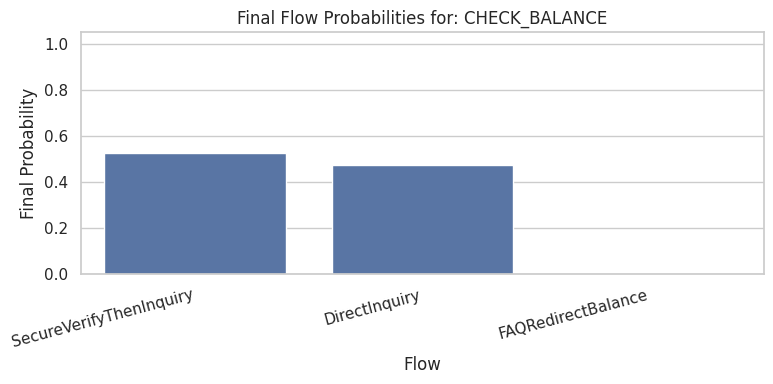

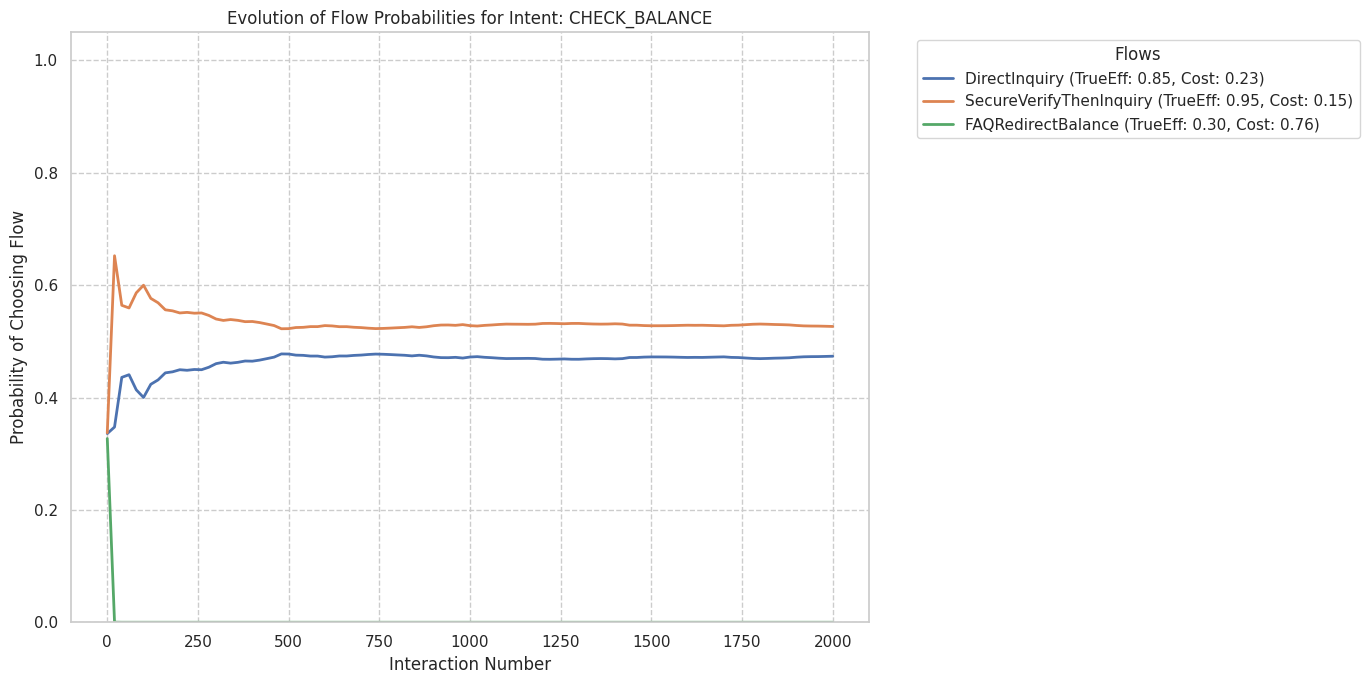


Intent: TRANSFER_FUNDS
                        Flow  Final Probability  True Effectiveness  Cost  \
1  GuidedTransferWithConfirm              0.558               0.900 0.240   
0              QuickTransfer              0.442               0.700 0.370   
2     ShowTransferLimitsInfo              0.000               0.450 0.620   

   Observed Trials  Observed Success Rate  
1          346.000                  0.919  
0          282.000                  0.727  
2            1.000                  0.000  


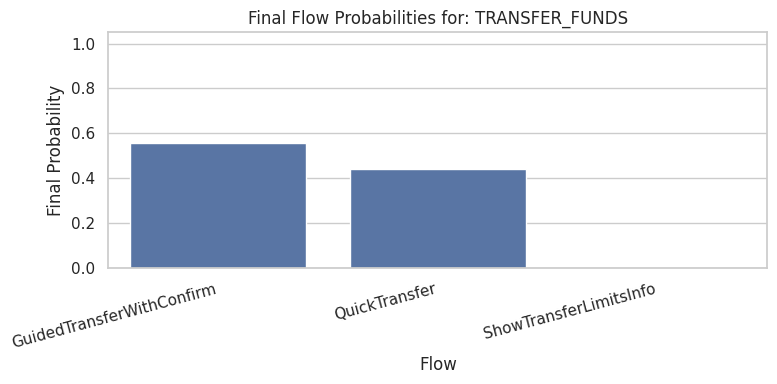

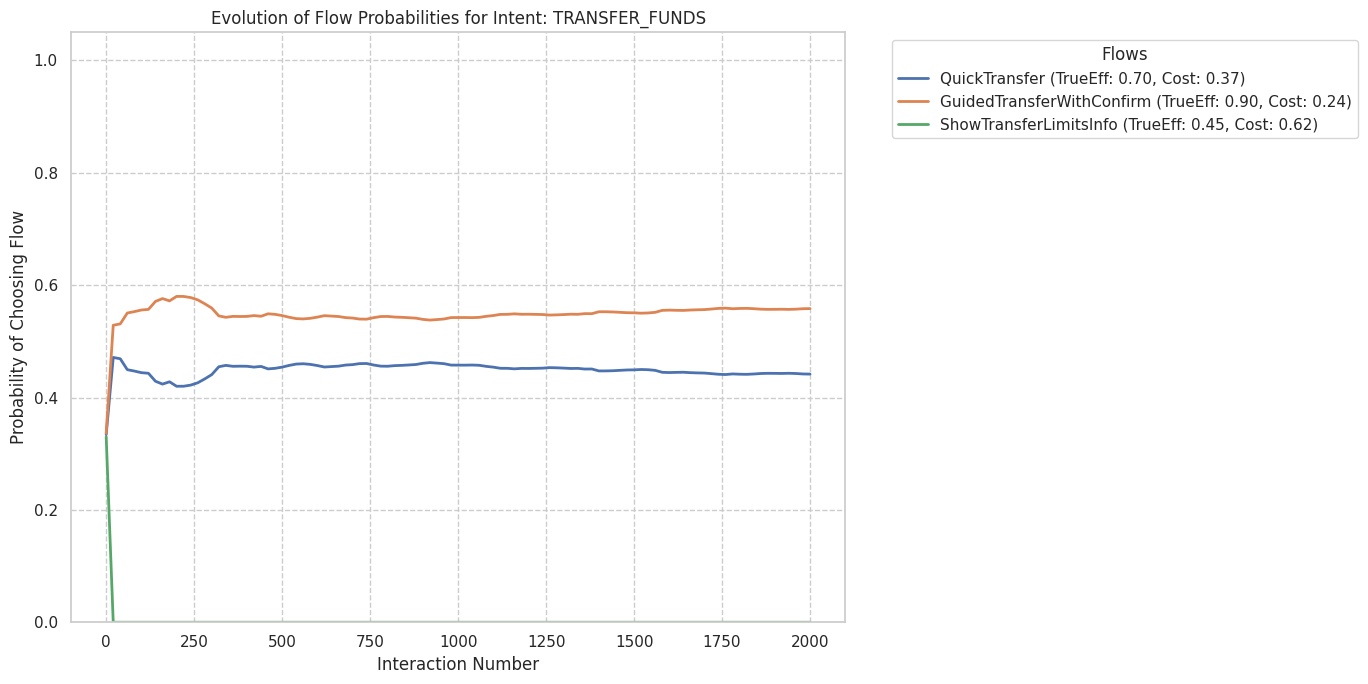


Intent: RESET_PASSWORD
                    Flow  Final Probability  True Effectiveness  Cost  \
2         EmailLinkReset              0.384               0.880 0.230   
0          SMS_OTP_Reset              0.353               0.800 0.260   
1  SecurityQuestionReset              0.263               0.650 0.480   

   Observed Trials  Observed Success Rate  
2          270.000                  0.893  
0          273.000                  0.821  
1          160.000                  0.606  


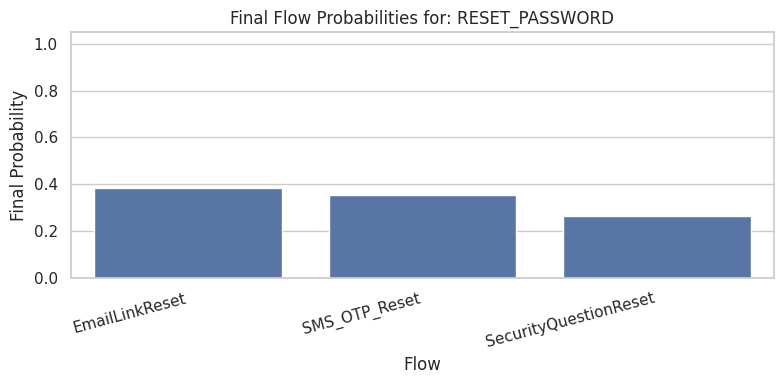

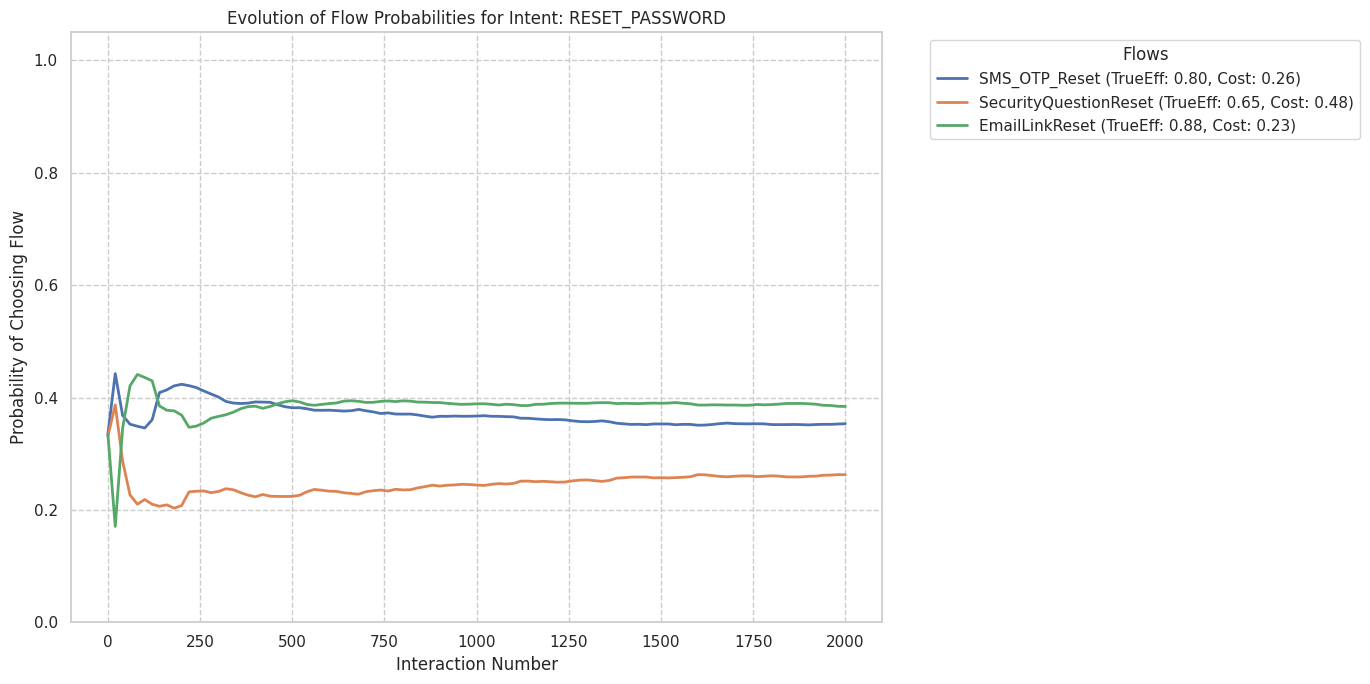


--- Potential Insights ---
1. Observe which flows gained the highest probability. Are they the ones with high true effectiveness and/or low cost?
2. Check if observed success rates are converging towards true effectiveness for flows with many trials.
3. The system should learn to balance the trade-off between high effectiveness and high cost.
4. Low-cost, moderately effective flows might be preferred over high-cost, high-effectiveness flows if the OT cost balancing is significant.


In [15]:
if history_records:
    final_combined_history_df = pd.concat(history_records)
else:
    print("No history was recorded during the simulation. Cannot generate final plots or detailed analysis.")
    final_combined_history_df = pd.DataFrame() # Create empty df to avoid errors later


print("\n--- Detailed Final Analysis for Each Intent ---")
for intent_name in INTENTS_CONFIG.keys():
    print(f"\nIntent: {intent_name}")
    intent_data = INTENTS_CONFIG[intent_name]

    # Get final probabilities
    final_probs = optimizer.get_current_strategy(intent_name)

    # Create a summary table for this intent
    summary_list = []
    if len(final_probs) == len(intent_data["flows"]): # Ensure probability array matches number of flows
        for i, flow_name in enumerate(intent_data["flows"]):
            summary_list.append({
                "Flow": flow_name,
                "Final Probability": final_probs[i],
                "True Effectiveness": intent_data["true_effectiveness"][i],
                "Cost": FLOW_COSTS_CONFIG[intent_name][flow_name],
                "Observed Trials": optimizer.flow_observed_total_counts[intent_name][i],
                "Observed Success Rate": (optimizer.flow_observed_success_counts[intent_name][i] /
                                         optimizer.flow_observed_total_counts[intent_name][i])
                                         if optimizer.flow_observed_total_counts[intent_name][i] > 0 else 0.0
            })
    else:
        print(f"  Warning: Mismatch in number of flows and probabilities for {intent_name}. Skipping summary table.")

    if summary_list: # Only proceed if summary_list was populated
        intent_summary_df = pd.DataFrame(summary_list).sort_values(by="Final Probability", ascending=False)
        print(intent_summary_df)

        # Bar chart of final probabilities
        plt.figure(figsize=(8,4))
        sns.barplot(x="Flow", y="Final Probability", data=intent_summary_df)
        plt.title(f"Final Flow Probabilities for: {intent_name}")
        plt.xticks(rotation=15, ha="right")
        plt.ylim(0, 1.05)
        plt.tight_layout()
        plt.show()

    # Plotting evolution for this specific intent
    if not final_combined_history_df.empty:
        plot_strategy_evolution(final_combined_history_df, intent_name)
    elif not summary_list: # If summary_list is also empty, means we probably can't plot
        print(f"  Skipping evolution plot for {intent_name} as no history or summary data is available.")


print("\n--- Potential Insights ---")
print("1. Observe which flows gained the highest probability. Are they the ones with high true effectiveness and/or low cost?")
print("2. Check if observed success rates are converging towards true effectiveness for flows with many trials.")
print("3. The system should learn to balance the trade-off between high effectiveness and high cost.")
print("4. Low-cost, moderately effective flows might be preferred over high-cost, high-effectiveness flows if the OT cost balancing is significant.")